# Two-Tower Initialization (Hackathon Scaffold)

This notebook:
1. Loads `jobs` + `users` from `hireup.db`.
2. Initializes unit-normalized random vectors for both towers.
3. Builds a local vector DB file (`two_tower_vecdb.sqlite`) keyed by `job_id` and `user_id` with metadata.
4. Runs LLM-guided pairwise/choice updates (steps 3-6) with parallelized requests.

Model used for all LLM decisions: `gpt-5-nano`.

In [31]:
from __future__ import annotations

import json
import os
import random
import re
import sqlite3
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
from dotenv import load_dotenv
from openai import OpenAI


In [32]:
# ---------- Config ----------
SEED = 7
EMBED_DIM = 8
LLM_MODEL = 'gpt-5-nano'
MAX_WORKERS = 6
LLM_MAX_OUTPUT_TOKENS = 24

# Update dynamics (always re-normalize to unit sphere)
PULL_LR = 0.14
PUSH_LR = 0.04

# Iterations (raise these for stronger clustering; this is a practical starter)
JOB_CLUSTER_ITERS = 30
USER_CLUSTER_ITERS = 250
USER_TO_JOB_ITERS = 250
JOB_TO_USER_ITERS = 30

# Save checkpoint to vecdb every N completed updates
SAVE_EVERY = 50

# Paths
DB_CANDIDATES = [
    Path('../hireup.db'),
    Path('hireup.db'),
    Path('../backend/hireup.db'),
    Path('backend/hireup.db'),
]
VECDB_PATH = Path('two_tower_vecdb.sqlite')

random.seed(SEED)
np.random.seed(SEED)

load_dotenv(Path('../.env'))
load_dotenv(Path('.env'))

api_key = os.getenv('OPENAI_API_KEY', '').strip()
if not api_key:
    raise RuntimeError('OPENAI_API_KEY not found. Put it in .env')

client = OpenAI(api_key=api_key)

def resolve_main_db() -> Path:
    existing = [p for p in DB_CANDIDATES if p.exists()]
    if not existing:
        raise FileNotFoundError(f'No DB found. Checked: {[str(p) for p in DB_CANDIDATES]}')

    for p in existing:
        with sqlite3.connect(p) as conn:
            tables = {r[0] for r in conn.execute("SELECT name FROM sqlite_master WHERE type='table'")}
            if 'jobs' in tables and 'users' in tables:
                return p
    return existing[0]

MAIN_DB_PATH = resolve_main_db()
print('Using source DB:', MAIN_DB_PATH.resolve())
print('Vector DB file:', VECDB_PATH.resolve())

Using source DB: /Users/hjiang/Documents/HireUp/hireup.db
Vector DB file: /Users/hjiang/Documents/HireUp/two-tower/two_tower_vecdb.sqlite


In [33]:
# ---------- Data loading ----------
with sqlite3.connect(MAIN_DB_PATH) as conn:
    conn.row_factory = sqlite3.Row

    jobs_rows = conn.execute(
        """
        SELECT
            id,
            company_id,
            title,
            description,
            skills,
            location,
            salary_range,
            status,
            created_at
        FROM jobs
        WHERE COALESCE(TRIM(description), '') <> ''
        """
    ).fetchall()

    users_rows = conn.execute(
        """
        SELECT
            id,
            email,
            name,
            resume_text,
            objective,
            career_objective,
            interests,
            created_at
        FROM users
        WHERE COALESCE(TRIM(resume_text), '') <> ''
        """
    ).fetchall()

jobs = [dict(r) for r in jobs_rows]
users = [dict(r) for r in users_rows]

if len(jobs) < 5:
    raise RuntimeError(f'Need >= 5 jobs with description; found {len(jobs)}')
if len(users) < 5:
    raise RuntimeError(f'Need >= 5 users with resume_text; found {len(users)}')

job_ids = [j['id'] for j in jobs]
user_ids = [u['id'] for u in users]

jobs_by_id = {j['id']: j for j in jobs}
users_by_id = {u['id']: u for u in users}

print(f'Loaded {len(jobs)} jobs and {len(users)} users')
print('Example job:', jobs[0]['id'], jobs[0]['title'])
print('Example user:', users[0]['id'], users[0]['email'])

Loaded 64 jobs and 1479 users
Example job: 1ee7ae2f-bed9-4367-bac2-8f80a0156a60 Software Engineer Intern
Example user: e5d21abf-cf73-42e1-b461-3c58fe330ddb owenzhang@gmail.com


In [34]:
# ---------- VecDB + vector utilities ----------
def normalize(v: np.ndarray) -> np.ndarray:
    n = float(np.linalg.norm(v))
    if n <= 1e-12:
        w = np.random.normal(size=v.shape[0]).astype(np.float32)
        return w / np.linalg.norm(w)
    return (v / n).astype(np.float32)

def rand_unit(dim: int) -> np.ndarray:
    return normalize(np.random.normal(size=dim).astype(np.float32))

job_vecs: Dict[str, np.ndarray] = {jid: rand_unit(EMBED_DIM) for jid in job_ids}
user_vecs: Dict[str, np.ndarray] = {uid: rand_unit(EMBED_DIM) for uid in user_ids}

def compact_job_metadata(j: dict) -> dict:
    return {
        'company_id': j.get('company_id'),
        'title': j.get('title'),
        'description': (j.get('description') or '')[:2000],
        'skills': j.get('skills'),
        'location': j.get('location'),
        'salary_range': j.get('salary_range'),
        'status': j.get('status'),
    }

def compact_user_metadata(u: dict) -> dict:
    return {
        'email': u.get('email'),
        'name': u.get('name'),
        'resume_text': (u.get('resume_text') or '')[:4000],
        'objective': u.get('objective'),
        'career_objective': u.get('career_objective'),
        'interests': u.get('interests'),
    }

job_meta = {jid: compact_job_metadata(jobs_by_id[jid]) for jid in job_ids}
user_meta = {uid: compact_user_metadata(users_by_id[uid]) for uid in user_ids}

def init_vecdb(path: Path) -> None:
    with sqlite3.connect(path) as conn:
        conn.execute(
            """
            CREATE TABLE IF NOT EXISTS job_vectors (
                id TEXT PRIMARY KEY,
                vector_json TEXT NOT NULL,
                metadata_json TEXT NOT NULL,
                updated_at TEXT DEFAULT (datetime('now'))
            )
            """
        )
        conn.execute(
            """
            CREATE TABLE IF NOT EXISTS user_vectors (
                id TEXT PRIMARY KEY,
                vector_json TEXT NOT NULL,
                metadata_json TEXT NOT NULL,
                updated_at TEXT DEFAULT (datetime('now'))
            )
            """
        )

def persist_all(path: Path) -> None:
    with sqlite3.connect(path) as conn:
        conn.execute('DELETE FROM job_vectors')
        conn.execute('DELETE FROM user_vectors')

        conn.executemany(
            """
            INSERT INTO job_vectors (id, vector_json, metadata_json, updated_at)
            VALUES (?, ?, ?, datetime('now'))
            """,
            [
                (jid, json.dumps(job_vecs[jid].tolist()), json.dumps(job_meta[jid]))
                for jid in job_ids
            ],
        )
        conn.executemany(
            """
            INSERT INTO user_vectors (id, vector_json, metadata_json, updated_at)
            VALUES (?, ?, ?, datetime('now'))
            """,
            [
                (uid, json.dumps(user_vecs[uid].tolist()), json.dumps(user_meta[uid]))
                for uid in user_ids
            ],
        )

init_vecdb(VECDB_PATH)
persist_all(VECDB_PATH)

print('Initialized vecdb with random unit vectors')
print('jobs:', len(job_vecs), '| users:', len(user_vecs))

Initialized vecdb with random unit vectors
jobs: 64 | users: 1479


In [35]:
# ---------- LLM helpers ----------
def extract_json_object(text: str) -> dict:
    text = (text or '').strip()
    try:
        return json.loads(text)
    except Exception:
        pass

    m = re.search(r'\{.*\}', text, flags=re.S)
    if not m:
        raise ValueError(f'No JSON object in model output: {text[:200]}')
    return json.loads(m.group(0))

def llm_json(system_prompt: str, user_prompt: str, retries: int = 2, fallback: dict | None = None) -> dict:
    last_err = None
    for attempt in range(retries):
        try:
            resp = client.responses.create(
                model=LLM_MODEL,
                input=[
                    {'role': 'system', 'content': system_prompt},
                    {'role': 'user', 'content': user_prompt},
                ],
                max_output_tokens=LLM_MAX_OUTPUT_TOKENS,
            )
            return extract_json_object(resp.output_text)
        except Exception as e:
            last_err = e
            time.sleep(0.8 * (attempt + 1))
    if fallback is not None:
        return fallback
    raise RuntimeError(f'LLM call failed after retries: {last_err}')

def safe_pair(out: dict) -> Tuple[int, int]:
    pair = out.get('pair', [0, 1])
    if not isinstance(pair, list) or len(pair) != 2:
        return (0, 1)
    i = int(pair[0]) if str(pair[0]).lstrip('-').isdigit() else 0
    j = int(pair[1]) if str(pair[1]).lstrip('-').isdigit() else 1
    i = max(0, min(4, i))
    j = max(0, min(4, j))
    if i == j:
        j = (j + 1) % 5
    return (i, j)

def safe_winner(out: dict) -> int:
    w = out.get('winner', 0)
    if not str(w).lstrip('-').isdigit():
        return 0
    w = int(w)
    return max(0, min(4, w))

def apply_pull(a: np.ndarray, b: np.ndarray, lr: float = PULL_LR) -> Tuple[np.ndarray, np.ndarray]:
    a0 = a.copy()
    b0 = b.copy()
    a1 = normalize((1.0 - lr) * a0 + lr * b0)
    b1 = normalize((1.0 - lr) * b0 + lr * a0)
    return a1, b1

def apply_push(anchor: np.ndarray, other: np.ndarray, lr: float = PUSH_LR) -> np.ndarray:
    return normalize(other - lr * anchor)

In [36]:
# ---------- Training steps 3-6 ----------
def step3_job_cluster_once(sample_ids: List[str]) -> Tuple[List[str], Tuple[int, int]]:
    payload = []
    for i, jid in enumerate(sample_ids):
        j = jobs_by_id[jid]
        payload.append({
            'i': i,
            'job_id': jid,
            'company_id': j.get('company_id'),
            'title': j.get('title'),
            'description': (j.get('description') or '')[:700],
            'skills': j.get('skills'),
        })

    system = (
        'You are ranking job-posting similarity for representation learning. '
        'Compare role scope, required skills, responsibilities, and candidate profile. '
        'Return ONLY JSON.'
    )
    user = (
        'Pick the TWO most similar jobs from exactly five options.\n'
        'Output exactly: {"pair":[i,j]} where i and j are distinct integers in [0,4].\n\n'
        f"Jobs:{json.dumps(payload, ensure_ascii=True, separators=(',', ':'))}"
    )

    out = llm_json(system, user, fallback={'pair': [0, 1]})
    i, j = safe_pair(out)
    return sample_ids, (int(i), int(j))

def step4_user_cluster_once(sample_ids: List[str]) -> Tuple[List[str], Tuple[int, int]]:
    payload = []
    for i, uid in enumerate(sample_ids):
        u = users_by_id[uid]
        payload.append({
            'i': i,
            'user_id': uid,
            'resume_text': (u.get('resume_text') or '')[:1000],
            'objective': u.get('objective'),
            'career_objective': u.get('career_objective'),
        })

    system = (
        'You are ranking candidate similarity for representation learning. '
        'Compare skills, experience areas, role preference, and trajectory. '
        'Return ONLY JSON.'
    )
    user = (
        'Pick the TWO most similar users from exactly five options.\n'
        'Output exactly: {"pair":[i,j]} where i and j are distinct integers in [0,4].\n\n'
        f"Users:{json.dumps(payload, ensure_ascii=True, separators=(',', ':'))}"
    )

    out = llm_json(system, user, fallback={'pair': [0, 1]})
    i, j = safe_pair(out)
    return sample_ids, (int(i), int(j))

def step5_user_to_jobs_once(uid: str, sample_job_ids: List[str]) -> Tuple[str, List[str], int]:
    u = users_by_id[uid]
    payload = []
    for i, jid in enumerate(sample_job_ids):
        j = jobs_by_id[jid]
        payload.append({
            'i': i,
            'job_id': jid,
            'company_id': j.get('company_id'),
            'title': j.get('title'),
            'description': (j.get('description') or '')[:700],
            'skills': j.get('skills'),
        })

    system = (
        'You are modeling job-application likelihood. '
        'Given one user and five jobs, choose the single job this user would most likely apply to. '
        'Use skill match, domain match, seniority fit, and explicit interests/objectives. '
        'Return ONLY JSON.'
    )
    user_payload = {
        'user_id': uid,
        'resume_text': (u.get('resume_text') or '')[:1000],
        'objective': u.get('objective'),
        'career_objective': u.get('career_objective'),
    }
    user = (
        'Output exactly: {"winner":i} where i is in [0,4].\n\n'
        f"User:{json.dumps(user_payload, ensure_ascii=True, separators=(',', ':'))}\n"
        f"Jobs:{json.dumps(payload, ensure_ascii=True, separators=(',', ':'))}"
    )

    out = llm_json(system, user, fallback={'winner': 0})
    return uid, sample_job_ids, safe_winner(out)

def step6_job_to_users_once(jid: str, sample_user_ids: List[str]) -> Tuple[str, List[str], int]:
    j = jobs_by_id[jid]
    payload = []
    for i, uid in enumerate(sample_user_ids):
        u = users_by_id[uid]
        payload.append({
            'i': i,
            'user_id': uid,
            'resume_text': (u.get('resume_text') or '')[:1000],
            'objective': u.get('objective'),
            'career_objective': u.get('career_objective'),
        })

    system = (
        'You are modeling candidate selection likelihood. '
        'Given one job and five users, choose the single user most likely to be accepted. '
        'Use skills, scope alignment, role fit, and signal from resume evidence. '
        'Return ONLY JSON.'
    )
    job_payload = {
        'job_id': jid,
        'company_id': j.get('company_id'),
        'title': j.get('title'),
        'description': (j.get('description') or '')[:700],
        'skills': j.get('skills'),
    }
    user = (
        'Output exactly: {"winner":i} where i is in [0,4].\n\n'
        f"Job:{json.dumps(job_payload, ensure_ascii=True, separators=(',', ':'))}\n"
        f"Users:{json.dumps(payload, ensure_ascii=True, separators=(',', ':'))}"
    )

    out = llm_json(system, user, fallback={'winner': 0})
    return jid, sample_user_ids, safe_winner(out)

def run_parallel(total_iters: int, make_task, apply_result, label: str) -> None:
    done = 0
    failures = 0
    while done < total_iters:
        batch = min(MAX_WORKERS, total_iters - done)
        futures = []
        with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
            for _ in range(batch):
                futures.append(ex.submit(make_task))

            for f in as_completed(futures):
                try:
                    result = f.result()
                    apply_result(result)
                except Exception as e:
                    failures += 1
                    if failures <= 5 or failures % 20 == 0:
                        print(f'[{label}] task failed ({failures}): {e}')
                done += 1

                if done % SAVE_EVERY == 0:
                    persist_all(VECDB_PATH)
                if done % 20 == 0 or done == total_iters:
                    print(f'[{label}] {done}/{total_iters} (failures={failures})')

# Step 3 update
def make_step3_task():
    sample_ids = random.sample(job_ids, 5)
    return step3_job_cluster_once(sample_ids)

def apply_step3_result(result):
    sample_ids, (i, j) = result
    a_id = sample_ids[i]
    b_id = sample_ids[j]

    va, vb = apply_pull(job_vecs[a_id], job_vecs[b_id])
    job_vecs[a_id], job_vecs[b_id] = va, vb

    # No negative push: only pull matched pair together.

# Step 4 update
def make_step4_task():
    sample_ids = random.sample(user_ids, 5)
    return step4_user_cluster_once(sample_ids)

def apply_step4_result(result):
    sample_ids, (i, j) = result
    a_id = sample_ids[i]
    b_id = sample_ids[j]

    va, vb = apply_pull(user_vecs[a_id], user_vecs[b_id])
    user_vecs[a_id], user_vecs[b_id] = va, vb

    # No negative push: only pull matched pair together.

# Step 5 update
def make_step5_task():
    uid = random.choice(user_ids)
    sample_jobs = random.sample(job_ids, 5)
    return step5_user_to_jobs_once(uid, sample_jobs)

def apply_step5_result(result):
    uid, sample_jobs, winner_idx = result
    win_jid = sample_jobs[winner_idx]

    uv, jv = apply_pull(user_vecs[uid], job_vecs[win_jid])
    user_vecs[uid], job_vecs[win_jid] = uv, jv

    # No negative push for non-winning jobs.

# Step 6 update
def make_step6_task():
    jid = random.choice(job_ids)
    sample_users = random.sample(user_ids, 5)
    return step6_job_to_users_once(jid, sample_users)

def apply_step6_result(result):
    jid, sample_users, winner_idx = result
    win_uid = sample_users[winner_idx]

    jv, uv = apply_pull(job_vecs[jid], user_vecs[win_uid])
    job_vecs[jid], user_vecs[win_uid] = jv, uv

    # No negative push for non-winning users.

In [37]:
# ---------- Run schedule ----------
# Each round runs the full configured iteration counts.
ROUNDS = 1
if ROUNDS <= 0:
    raise ValueError('ROUNDS must be >= 1')

for r in range(ROUNDS):
    print(f'\n=== Round {r + 1}/{ROUNDS} ===')

    run_parallel(JOB_CLUSTER_ITERS, make_step3_task, apply_step3_result, 'step3 jobs->jobs')
    run_parallel(USER_CLUSTER_ITERS, make_step4_task, apply_step4_result, 'step4 users->users')
    run_parallel(USER_TO_JOB_ITERS, make_step5_task, apply_step5_result, 'step5 user->jobs')
    run_parallel(JOB_TO_USER_ITERS, make_step6_task, apply_step6_result, 'step6 job->users')

    persist_all(VECDB_PATH)

# Final persist + quick checks
persist_all(VECDB_PATH)

job_norms = np.array([np.linalg.norm(v) for v in job_vecs.values()])
user_norms = np.array([np.linalg.norm(v) for v in user_vecs.values()])

print('\nSaved vecdb at:', VECDB_PATH.resolve())
print('Job norms min/max:', float(job_norms.min()), float(job_norms.max()))
print('User norms min/max:', float(user_norms.min()), float(user_norms.max()))
print('Sample job vector dims:', len(next(iter(job_vecs.values()))))
print('Sample user vector dims:', len(next(iter(user_vecs.values()))))



=== Round 1/1 ===
[step3 jobs->jobs] 20/30 (failures=0)
[step3 jobs->jobs] 30/30 (failures=0)
[step4 users->users] 20/250 (failures=0)
[step4 users->users] 40/250 (failures=0)
[step4 users->users] 60/250 (failures=0)
[step4 users->users] 80/250 (failures=0)
[step4 users->users] 100/250 (failures=0)
[step4 users->users] 120/250 (failures=0)
[step4 users->users] 140/250 (failures=0)
[step4 users->users] 160/250 (failures=0)
[step4 users->users] 180/250 (failures=0)
[step4 users->users] 200/250 (failures=0)
[step4 users->users] 220/250 (failures=0)
[step4 users->users] 240/250 (failures=0)
[step4 users->users] 250/250 (failures=0)
[step5 user->jobs] 20/250 (failures=0)
[step5 user->jobs] 40/250 (failures=0)
[step5 user->jobs] 60/250 (failures=0)
[step5 user->jobs] 80/250 (failures=0)
[step5 user->jobs] 100/250 (failures=0)
[step5 user->jobs] 120/250 (failures=0)
[step5 user->jobs] 140/250 (failures=0)
[step5 user->jobs] 160/250 (failures=0)
[step5 user->jobs] 180/250 (failures=0)


KeyboardInterrupt: 

In [ ]:
# ---------- Evaluation helpers ----------
from itertools import combinations

def vec_best_pair(ids: List[str], vecs: Dict[str, np.ndarray]) -> Tuple[int, int]:
    best = None
    best_score = -1e18
    for i, j in combinations(range(len(ids)), 2):
        score = float(np.dot(vecs[ids[i]], vecs[ids[j]]))
        if score > best_score:
            best_score = score
            best = (i, j)
    return best if best is not None else (0, 1)

def vec_best_from_anchor(anchor_vec: np.ndarray, cand_ids: List[str], cand_vecs: Dict[str, np.ndarray]) -> int:
    best_i = 0
    best_score = -1e18
    for i, cid in enumerate(cand_ids):
        score = float(np.dot(anchor_vec, cand_vecs[cid]))
        if score > best_score:
            best_score = score
            best_i = i
    return best_i

def llm_user_pair(sample_user_ids: List[str]) -> Tuple[int, int]:
    payload = []
    for i, uid in enumerate(sample_user_ids):
        u = users_by_id[uid]
        payload.append({
            'i': i,
            'user_id': uid,
            'resume_text': (u.get('resume_text') or '')[:900],
            'objective': u.get('objective'),
            'career_objective': u.get('career_objective'),
        })

    system = 'You compare candidate similarity. Return only JSON.'
    user = (
        'Pick the TWO most similar users. Output exactly: {\"pair\":[i,j]} with distinct i,j in [0,4].\n'
        f"Users:{json.dumps(payload, ensure_ascii=True, separators=(',', ':'))}"
    )
    out = llm_json(system, user, fallback={'pair': [0, 1]})
    return safe_pair(out)

def llm_job_pair(sample_job_ids: List[str]) -> Tuple[int, int]:
    payload = []
    for i, jid in enumerate(sample_job_ids):
        j = jobs_by_id[jid]
        payload.append({
            'i': i,
            'job_id': jid,
            'company_id': j.get('company_id'),
            'title': j.get('title'),
            'description': (j.get('description') or '')[:700],
            'skills': j.get('skills'),
        })

    system = 'You compare job posting similarity. Return only JSON.'
    user = (
        'Pick the TWO most similar jobs. Output exactly: {\"pair\":[i,j]} with distinct i,j in [0,4].\n'
        f"Jobs:{json.dumps(payload, ensure_ascii=True, separators=(',', ':'))}"
    )
    out = llm_json(system, user, fallback={'pair': [0, 1]})
    return safe_pair(out)

def llm_user_for_job(anchor_job_id: str, sample_user_ids: List[str]) -> int:
    j = jobs_by_id[anchor_job_id]
    payload = []
    for i, uid in enumerate(sample_user_ids):
        u = users_by_id[uid]
        payload.append({
            'i': i,
            'user_id': uid,
            'resume_text': (u.get('resume_text') or '')[:900],
            'objective': u.get('objective'),
            'career_objective': u.get('career_objective'),
        })

    job_payload = {
        'job_id': anchor_job_id,
        'company_id': j.get('company_id'),
        'title': j.get('title'),
        'description': (j.get('description') or '')[:700],
        'skills': j.get('skills'),
    }

    system = 'You rank candidate fit for a job. Return only JSON.'
    user = (
        'Pick the single best user for the job. Output exactly: {\"winner\":i} where i in [0,4].\n'
        f"Job:{json.dumps(job_payload, ensure_ascii=True, separators=(',', ':'))}\n"
        f"Users:{json.dumps(payload, ensure_ascii=True, separators=(',', ':'))}"
    )
    out = llm_json(system, user, fallback={'winner': 0})
    return safe_winner(out)

def llm_job_for_user(anchor_user_id: str, sample_job_ids: List[str]) -> int:
    u = users_by_id[anchor_user_id]
    payload = []
    for i, jid in enumerate(sample_job_ids):
        j = jobs_by_id[jid]
        payload.append({
            'i': i,
            'job_id': jid,
            'company_id': j.get('company_id'),
            'title': j.get('title'),
            'description': (j.get('description') or '')[:700],
            'skills': j.get('skills'),
        })

    user_payload = {
        'user_id': anchor_user_id,
        'resume_text': (u.get('resume_text') or '')[:900],
        'objective': u.get('objective'),
        'career_objective': u.get('career_objective'),
    }

    system = 'You rank job interest likelihood for a user. Return only JSON.'
    user = (
        'Pick the single best job for the user. Output exactly: {\"winner\":i} where i in [0,4].\n'
        f"User:{json.dumps(user_payload, ensure_ascii=True, separators=(',', ':'))}\n"
        f"Jobs:{json.dumps(payload, ensure_ascii=True, separators=(',', ':'))}"
    )
    out = llm_json(system, user, fallback={'winner': 0})
    return safe_winner(out)


In [ ]:
# ---------- Evaluation run (10x each metric) ----------
EVAL_RUNS = 10

stats = {
    'user_pair': {'correct': 0, 'total': EVAL_RUNS, 'last': None},
    'job_pair': {'correct': 0, 'total': EVAL_RUNS, 'last': None},
    'job_to_user': {'correct': 0, 'total': EVAL_RUNS, 'last': None},
    'user_to_job': {'correct': 0, 'total': EVAL_RUNS, 'last': None},
}

# 1) 5 random users -> closest pair
for run in range(EVAL_RUNS):
    sample_ids = random.sample(user_ids, 5)
    vec_pair = vec_best_pair(sample_ids, user_vecs)
    llm_pair = llm_user_pair(sample_ids)

    match = set(vec_pair) == set(llm_pair)
    stats['user_pair']['correct'] += int(match)

    if run == EVAL_RUNS - 1:
        stats['user_pair']['last'] = {
            'sample_user_ids': sample_ids,
            'vec_pair_idx': vec_pair,
            'vec_pair_user_ids': [sample_ids[vec_pair[0]], sample_ids[vec_pair[1]]],
            'llm_pair_idx': llm_pair,
            'llm_pair_user_ids': [sample_ids[llm_pair[0]], sample_ids[llm_pair[1]]],
            'match': match,
        }

# 2) 5 random jobs -> closest pair
for run in range(EVAL_RUNS):
    sample_ids = random.sample(job_ids, 5)
    vec_pair = vec_best_pair(sample_ids, job_vecs)
    llm_pair = llm_job_pair(sample_ids)

    match = set(vec_pair) == set(llm_pair)
    stats['job_pair']['correct'] += int(match)

    if run == EVAL_RUNS - 1:
        stats['job_pair']['last'] = {
            'sample_job_ids': sample_ids,
            'vec_pair_idx': vec_pair,
            'vec_pair_job_ids': [sample_ids[vec_pair[0]], sample_ids[vec_pair[1]]],
            'llm_pair_idx': llm_pair,
            'llm_pair_job_ids': [sample_ids[llm_pair[0]], sample_ids[llm_pair[1]]],
            'match': match,
        }

# 3) 1 random job + 5 random users -> best user
for run in range(EVAL_RUNS):
    anchor_job_id = random.choice(job_ids)
    sample_user_ids = random.sample(user_ids, 5)

    vec_winner = vec_best_from_anchor(job_vecs[anchor_job_id], sample_user_ids, user_vecs)
    llm_winner = llm_user_for_job(anchor_job_id, sample_user_ids)

    match = (vec_winner == llm_winner)
    stats['job_to_user']['correct'] += int(match)

    if run == EVAL_RUNS - 1:
        stats['job_to_user']['last'] = {
            'anchor_job_id': anchor_job_id,
            'sample_user_ids': sample_user_ids,
            'vec_winner_idx': vec_winner,
            'vec_winner_user_id': sample_user_ids[vec_winner],
            'llm_winner_idx': llm_winner,
            'llm_winner_user_id': sample_user_ids[llm_winner],
            'match': match,
        }

# 4) 1 random user + 5 random jobs -> best job
for run in range(EVAL_RUNS):
    anchor_user_id = random.choice(user_ids)
    sample_job_ids = random.sample(job_ids, 5)

    vec_winner = vec_best_from_anchor(user_vecs[anchor_user_id], sample_job_ids, job_vecs)
    llm_winner = llm_job_for_user(anchor_user_id, sample_job_ids)

    match = (vec_winner == llm_winner)
    stats['user_to_job']['correct'] += int(match)

    if run == EVAL_RUNS - 1:
        stats['user_to_job']['last'] = {
            'anchor_user_id': anchor_user_id,
            'sample_job_ids': sample_job_ids,
            'vec_winner_idx': vec_winner,
            'vec_winner_job_id': sample_job_ids[vec_winner],
            'llm_winner_idx': llm_winner,
            'llm_winner_job_id': sample_job_ids[llm_winner],
            'match': match,
        }

overall_correct = sum(v['correct'] for v in stats.values())
overall_total = sum(v['total'] for v in stats.values())

print('=== Aggregate Stats ===')
for k, v in stats.items():
    acc = (v['correct'] / v['total']) if v['total'] else 0.0
    print(f"{k}: {v['correct']}/{v['total']} ({acc:.1%})")

print(f"overall: {overall_correct}/{overall_total} ({(overall_correct/overall_total):.1%})")

print('\n=== Last Run Details ===')
print('user_pair last:', stats['user_pair']['last'])
print('job_pair last:', stats['job_pair']['last'])
print('job_to_user last:', stats['job_to_user']['last'])
print('user_to_job last:', stats['user_to_job']['last'])

eval_results = {
    'stats': stats,
    'overall_correct': overall_correct,
    'overall_total': overall_total,
}


=== Aggregate Stats ===
user_pair: 1/10 (10.0%)
job_pair: 1/10 (10.0%)
job_to_user: 4/10 (40.0%)
user_to_job: 1/10 (10.0%)
overall: 7/40 (17.5%)

=== Last Run Details ===
user_pair last: {'sample_user_ids': ['8ee60b86-bea1-4820-94be-9bac81e35899', 'f19d05d5-d1c3-4a99-b405-addd66303bdc', '3c3f4134-e65c-4c50-bbda-2ead95758e0a', 'a3cc9b95-a871-43be-a4dd-9c03fbcaf5de', 'f3d22ae1-99d4-4d9d-a77d-7bb7aedfbfb5'], 'vec_pair_idx': (3, 4), 'vec_pair_user_ids': ['a3cc9b95-a871-43be-a4dd-9c03fbcaf5de', 'f3d22ae1-99d4-4d9d-a77d-7bb7aedfbfb5'], 'llm_pair_idx': (0, 1), 'llm_pair_user_ids': ['8ee60b86-bea1-4820-94be-9bac81e35899', 'f19d05d5-d1c3-4a99-b405-addd66303bdc'], 'match': False}
job_pair last: {'sample_job_ids': ['1583dc9f-0159-4f37-a7e1-f7fe399b2e9a', '2a14d227-3f01-4f71-a5ab-7478313ba60f', '1f48a4f9-858c-4f76-9888-6c04463bfb77', 'f90170d5-e891-49a8-a503-03458aedbea2', '0f44ddcf-ef95-4ba5-b1c1-87d5bf82c439'], 'vec_pair_idx': (2, 4), 'vec_pair_job_ids': ['1f48a4f9-858c-4f76-9888-6c04463bfb77', 

/Users/hjiang/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/hjiang/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/hjiang/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/hjiang/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/hjiang/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/hjiang/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transfo

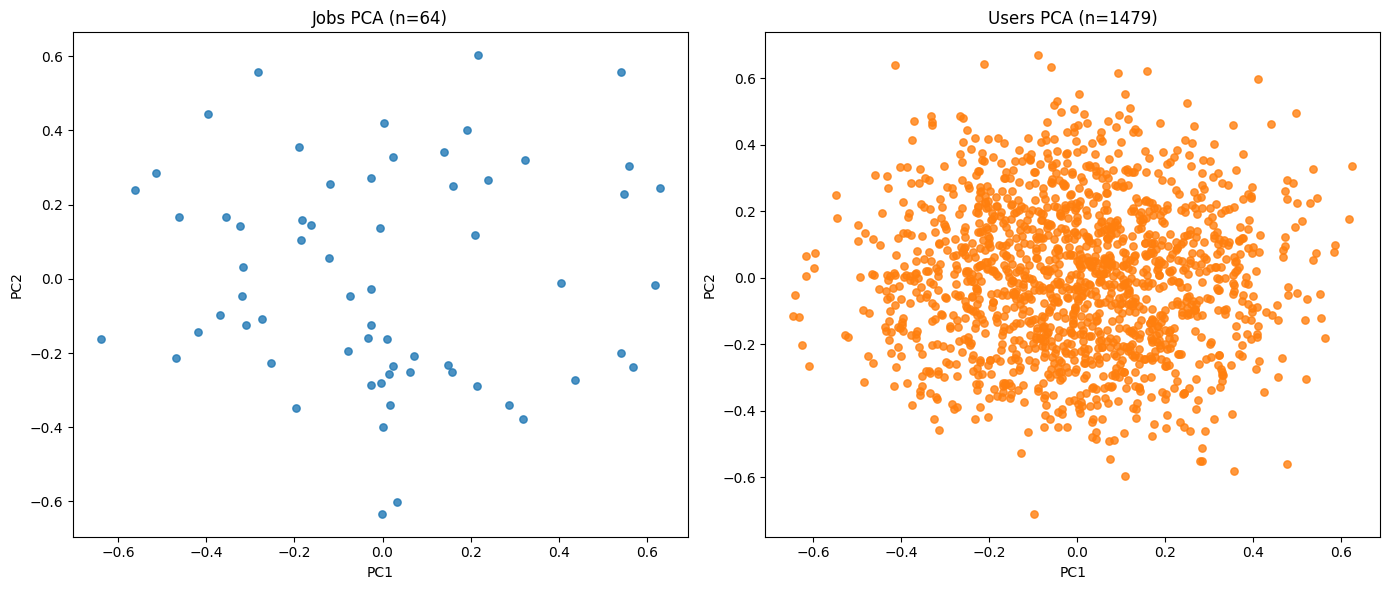

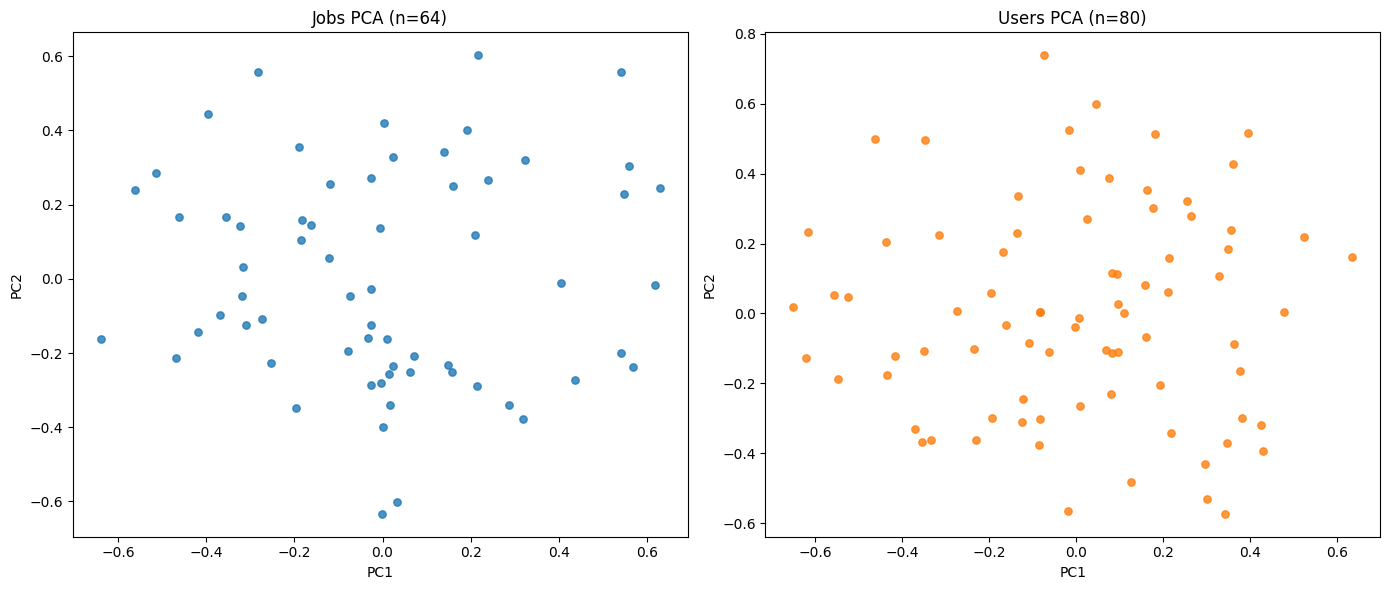

In [ ]:
# ---------- Embedding visualization ----------
import matplotlib.pyplot as plt

def _pca_2d(X: np.ndarray) -> np.ndarray:
    # Prefer sklearn PCA; fall back to SVD-based PCA if sklearn is unavailable.
    try:
        from sklearn.decomposition import PCA
        return PCA(n_components=2, random_state=SEED).fit_transform(X)
    except Exception:
        Xc = X - X.mean(axis=0, keepdims=True)
        _, _, vt = np.linalg.svd(Xc, full_matrices=False)
        comps = vt[:2].T
        return Xc @ comps

def visualize_embeddings(max_points: int | None = None, annotate: bool = False) -> None:
    """Plot 2D PCA projections of job/user tower vectors to inspect cluster formation."""
    job_items = list(job_vecs.items())
    user_items = list(user_vecs.items())

    if max_points is not None and max_points > 0:
        if len(job_items) > max_points:
            idx = np.random.choice(len(job_items), size=max_points, replace=False)
            job_items = [job_items[i] for i in idx]
        if len(user_items) > max_points:
            idx = np.random.choice(len(user_items), size=max_points, replace=False)
            user_items = [user_items[i] for i in idx]

    job_ids_local = [k for k, _ in job_items]
    user_ids_local = [k for k, _ in user_items]
    job_X = np.stack([v for _, v in job_items])
    user_X = np.stack([v for _, v in user_items])

    job_xy = _pca_2d(job_X)
    user_xy = _pca_2d(user_X)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].scatter(job_xy[:, 0], job_xy[:, 1], s=28, alpha=0.8, c='#1f77b4')
    axes[0].set_title(f'Jobs PCA (n={len(job_ids_local)})')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')

    axes[1].scatter(user_xy[:, 0], user_xy[:, 1], s=28, alpha=0.8, c='#ff7f0e')
    axes[1].set_title(f'Users PCA (n={len(user_ids_local)})')
    axes[1].set_xlabel('PC1')
    axes[1].set_ylabel('PC2')

    if annotate:
        for i, jid in enumerate(job_ids_local):
            axes[0].annotate(jid[:8], (job_xy[i, 0], job_xy[i, 1]), fontsize=7, alpha=0.75)
        for i, uid in enumerate(user_ids_local):
            axes[1].annotate(uid[:8], (user_xy[i, 0], user_xy[i, 1]), fontsize=7, alpha=0.75)

    plt.tight_layout()
    plt.show()

# Example:
visualize_embeddings()
visualize_embeddings(max_points=80, annotate=False)
